“House Taken Over” (“Casa Tomada”) by Julio Cortázar Translated by Paul Blackburn We  liked the house because,  apart from  its being old  and spacious (in  a day when old houses  go down for  a profitable  auction  of  their  construction  materials),  it  kept  the  memories  of  great‐grandparents,  our  paternal grandfather, our parents and the whole of childhood. Irene and I got used to staying in the house by ourselves, which was crazy, eight people could have lived in that place and not have gotten in each other's way. We rose at seven in the morning and got the cleaning done, and about eleven I left Irene to finish off whatever rooms and went to the kitchen. We lunched at noon precisely  then there was nothing left to do but a few dirty plates. It was pleasant to take lunch and commune with the great hollow, silent house, and it was enough for us just to keep it clean. We ended up thinking, at times, that that was what had  kept us from marrying. Irene turned down two suitors f

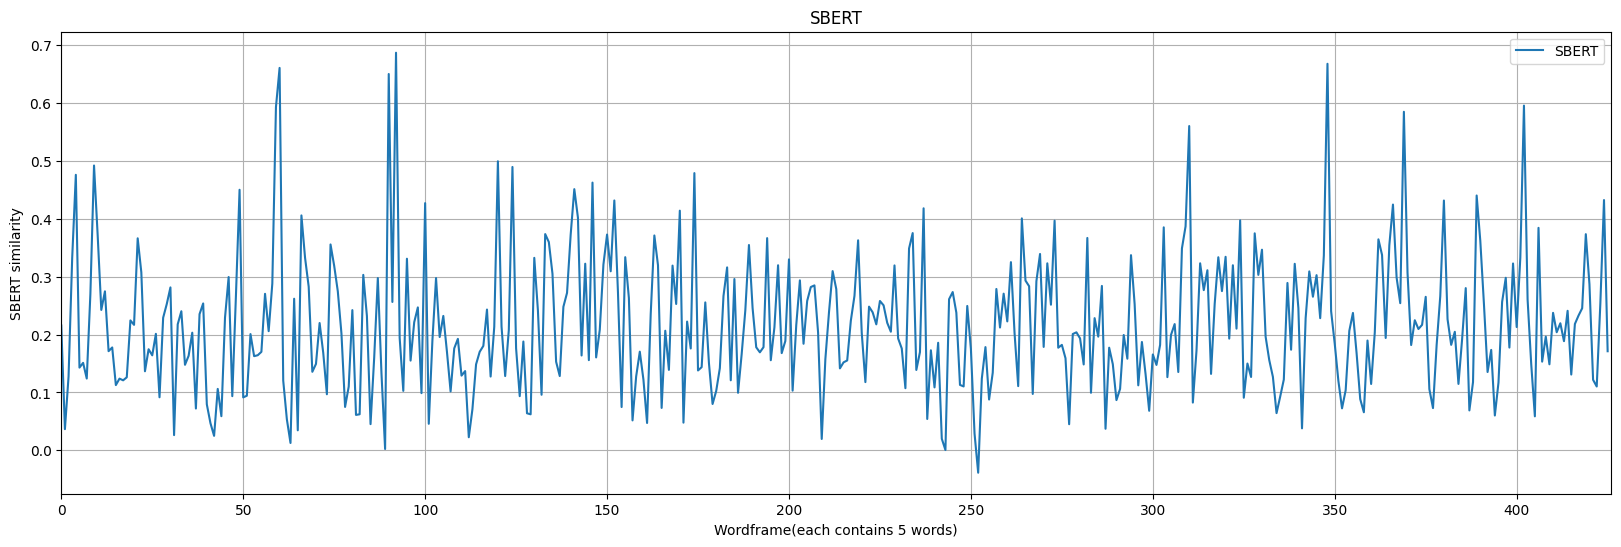

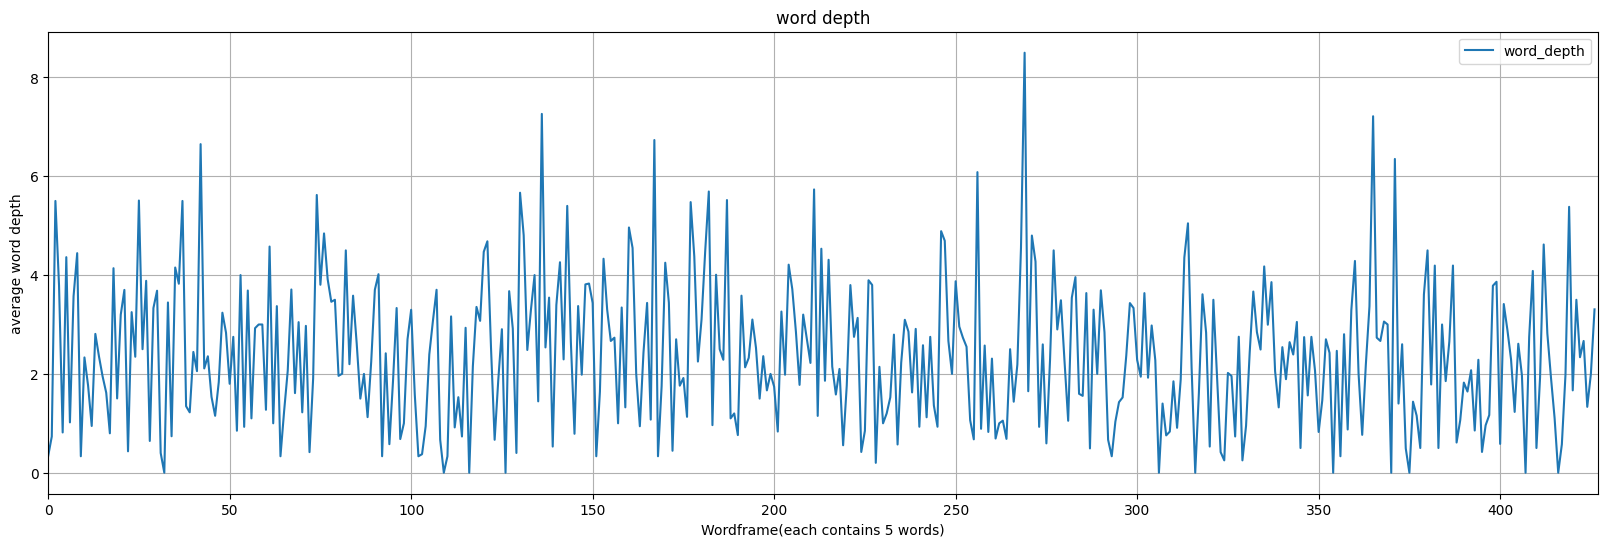

In [4]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util
from torch import embedding
from nltk.corpus import stopwords
from nltk.corpus import wordnet 
import nltk
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.datasets import make_moons
from scipy.stats import pearsonr
from scipy.signal import hilbert, chirp
import re
########################### superparameter
wordframe = 5 #number of words included in one frame
step = 5    #the sliding rate of the frame 
gcs = '..../something.txt'   #gcs = path of the input pdf file
pdf_genereated_path = '...../something.pdf' #the path for the pdf generated
csv_path = '...../something.csv' #path for the csv file generated
#################################
with open(gcs, encoding='utf-8') as f:
    import re
    text = f.read()
    text = text.replace(' - '," ").replace('-\n',"").replace('\n',' ')#.replace('\r',' ')
    talbe = text.maketrans(r':;"',"   ")
    text = text.translate(talbe)
    text_split = re.split(' +', text)
    print(text)
print(text_split)


#slicing of document
global all_sentences001
all_sentences001 = []

for word_num in range(0,len(text_split)-wordframe,step):
    x = ' '.join(text_split[word_num:word_num+5])
    all_sentences001.append(x)
#imports SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')
global SBERT 
SBERT= []
#calculates SBERT similarity between adjacent frames
def get_cosine_similarity(feature_vec_1, feature_vec_2):    
    return cosine_similarity(feature_vec_1.reshape(1, -1), feature_vec_2.reshape(1, -1))[0][0]
# Two lists of sentences
compared_words = []
for i in range(0,len(all_sentences001)-1):
    compared_words.append(f'{all_sentences001[i]}'+f'|||{all_sentences001[i+1]}')
    #Compute embedding for both lists
    embeddings1 = model.encode(all_sentences001[i], convert_to_tensor=True)
    embeddings2 = model.encode(all_sentences001[i+1], convert_to_tensor=True)
    cosine_scores = util.cos_sim(embeddings1, embeddings2)
    SBERT.append(get_cosine_similarity(embeddings1, embeddings2))


#calculates Words depth
stops = set(stopwords.words('english'))
word_depth_list = []
sentences = []
for word_num in range(0,len(text_split)-wordframe,step): #word_num is the index of the start of each frame
    
    words = text_split[word_num:word_num+wordframe]
    for word in words:
        if word in stops:
            words.remove(word)
    averaged_word_synset_depth = 0
    sentences.append(words)
    for words_num in range(0, len(words)): #words_num = the word within each frame
        if len(wordnet.synsets(str(words[words_num]))) > 0 : #if this word has more than 1 synset
            syns1 = wordnet.synsets(str(words[words_num]))
            syns1_num = len(syns1)#the number of synsets the word has
            for synsnum in range(0,syns1_num):  #adding depth of each synset of the word
                quick_synset_depth_average = 0
                if syns1[synsnum].min_depth() == 0:  # the min_depths of a word that is already the root is set to 1  
                    quick_synset_depth_average = 1
                
                else:
                    quick_synset_depth_average = syns1[synsnum].min_depth()
                
                averaged_word_synset_depth += quick_synset_depth_average/syns1_num
            
        else:
            continue

    average_min_depth = (averaged_word_synset_depth/len(words)) 
    word_depth_list.append(round(average_min_depth,4))





def createPDF(path):
    global pdfFile
    pdfFile = PdfPages(path)
createPDF(pdf_genereated_path)
# average_min_depth 是正常的先算出每個字的平均，再取許多字的平均
fig = plt.figure(figsize=(20,6))
#plt.rcParams["figure.figsize"] = (20, 6)
plt.plot(SBERT,label = "SBERT")
plt.xlabel(f"Wordframe(each contains {wordframe} words),step = {step}")
plt.ylabel("SBERT similarity")
plt.title("SBERT")
plt.xlim(0,len(SBERT))
plt.grid()
plt.legend()
plt.show
pdfFile.savefig(fig)

fig = plt.figure(figsize=(20,6))
#plt.rcParams["figure.figsize"] = (20, 6)
plt.plot(word_depth_list,label = "word_depth")
plt.xlabel(f"Wordframe(each contains {wordframe} words),step = {step}")
plt.ylabel("average word depth")
plt.title(f"word depth")
plt.xlim(0,len(word_depth_list))
plt.grid()
plt.legend()
plt.show
pdfFile.savefig(fig)
pdfFile.close() 


df = pd.DataFrame(list(zip(compared_words,SBERT,sentences,word_depth_list)),columns=['compared_sentences','SBERT','sentence','word_depth'])
df.to_csv(csv_path)